<a href="https://colab.research.google.com/github/gongx030/Etv2_pioneer/blob/master/Gene_set_enrichment_analysis_Immune_reponse_pathways_for_MEFs_vs_D1_and_D7_Flk1%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By Nikita Dsouza

The goal of this notebook is to use gene set enrichment analysis to see the pathways within immune reponse upregualted in Dox D7 Flk1+ and Dox D1 vs MEFs

In [ ]:
start_time0 <- Sys.time()

### Install R packages
A large fraction of the running time of this notebook is in installing the Seurat R package, since it has lots of dependencies and many of them use Rcpp which results in the need to compile lots of C++ code.

In [ ]:
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
BiocManager::install(c(
  'SummarizedExperiment', 'rhdf5', 'SingleCellExperiment', 'limma', 'goseq', 
  'stringr', 'ggplot2', 'TxDb.Mmusculus.UCSC.mm10.knownGene', 'org.Mm.eg.db',
  'wordcloud', 'plotrix', 'DESeq2','fgsea','cowplot','GO.db','GOfuncR','Mus.musculus'
), Ncpus = 2)
install.packages(c('farver', "Seurat"), Ncpus = 2)
install.packages('devtools')
devtools::install_github('rstudio/reticulate')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.13 (BiocManager 1.30.16), R 4.1.1 (2021-08-10)

Warning message:
“package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'stringr' 'ggplot2'”
Installing package(s) 'BiocVersion', 'SummarizedExperiment', 'rhdf5',
  'SingleCellExperiment', 'limma', 'goseq',
  'TxDb.Mmusculus.UCSC.mm10.knownGene', 'org.Mm.eg.db', 'wordcloud', 'plotrix',
  'DESeq2', 'fgsea', 'cowplot', 'GO.db', 'GOfuncR', 'Mus.musculus'

also installing the dependencies ‘Rhtslib’, ‘rjson’, ‘filelock’, ‘formatR’, ‘zlibbioc’, ‘bitops’, ‘XML’, ‘Rsamtools’, ‘GenomicAlignments’, ‘restfulr’, ‘plogr’, ‘png’, ‘BiocFileCache’, ‘lambda.r’, ‘futile.options’, ‘xtable’, ‘matrixStats’, ‘XVector’, ‘RCurl’, ‘GenomeInfoDbData’, ‘rtracklay


✔  checking for file ‘/tmp/Rtmp0Lny9D/remotes4f2548b202/rstudio-reticulate-3eda565/DESCRIPTION’
─  preparing ‘reticulate’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘reticulate_1.22-9000.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(SummarizedExperiment)
library(RColorBrewer)
library(plyr)
library(dplyr)
library(parallel)
library(ggplot2)
library(goseq)
library(stringr)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(org.Mm.eg.db)
library(wordcloud)
library(plotrix)
library(DESeq2)
library(fgsea)
library(cowplot)
library(tidyverse)
library(magrittr)
library(GO.db)
library(GOfuncR)
library(Mus.musculus)
library(SingleCellExperiment)
library(Seurat)

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, ro

# Get immune reponse related child terms from GO database

In [ ]:
goterms <- get_child_nodes("GO:0006955") 


In [ ]:
head(goterms)

,parent_go_id,child_go_id,child_name,distance
,<chr>,<chr>,<chr>,<int>
1,GO:0006955,GO:0006955,immune response,0
2,GO:0006955,GO:0002250,adaptive immune response,1
3,GO:0006955,GO:0002251,organ or tissue specific immune response,1
4,GO:0006955,GO:0002263,cell activation involved in immune response,1
5,GO:0006955,GO:0002367,cytokine production involved in immune response,1
6,GO:0006955,GO:0002418,immune response to tumor cell,1


## Terms containing Pathway and Cascade and exluding regulation, positive and negative terms for the pathways

In [ ]:
pathway_terms <- goterms %>% filter(str_detect(child_name, 'pathway|cascade')) %>% filter(!str_detect(child_name, 'regulation|negative|positive'))

In [ ]:
go_genes <- get_anno_genes(go_ids=pathway_terms$child_go_id, database = 'Mus.musculus')

find child nodes of GO-categories...

find genes annotated to child nodes using database 'Mus.musculus'...

Remove annotated categories not present in GO-graph...

Done.



In [ ]:
head(go_genes)

,go_id,gene
,<chr>,<chr>
1,GO:0001867,A2m
2,GO:0001867,Colec11
3,GO:0001867,Fcna
4,GO:0001867,Fcnb
5,GO:0001867,Krt1
6,GO:0001867,Masp1


## Get the gene set for all pathways in the parent inflammatory reponse GO terms

In [ ]:
go_set <- split(go_genes$gene,go_genes$go_id)

In [ ]:
names(go_set) <- goterms$child_name[match(names(go_set),goterms$child_go_id)]

In [ ]:
head(go_set)

$`complement activation, lectin pathway`
 [1] "A2m"      "Colec11"  "Fcna"     "Fcnb"     "Krt1"     "Masp1"   
 [7] "Masp2"    "Mbl1"     "Mbl2"     "Mfap4"    "Serping1"

$`innate immune response activating cell surface receptor signaling pathway`
[1] "Fcnb"   "Ffar2"  "Klrd1"  "Klre1"  "Klrk1"  "Tlr2"   "Tyrobp"

$`stimulatory killer cell immunoglobulin-like receptor signaling pathway`
[1] "Tyrobp"

$`stimulatory C-type lectin receptor signaling pathway`
[1] "Klrd1"  "Klre1"  "Klrk1"  "Tyrobp"

$`immune response-activating cell surface receptor signaling pathway`
  [1] "Abl1"       "Ada"        "Appl1"      "Appl2"      "Bag6"      
  [6] "Bax"        "Bcar1"      "Bcl10"      "Bcl2"       "Bcl2a1d"   
 [11] "Blk"        "Blnk"       "Bmx"        "Braf"       "Btn1a1"    
 [16] "Btn2a2"     "Btnl1"      "Btnl10"     "Btnl2"      "Btnl4"     
 [21] "Btnl6"      "Btnl9"      "C3ar1"      "C5ar1"      "C5ar2"     
 [26] "Cacna1f"    "Cacnb3"     "Cacnb4"     "Card11"     "Carmil2"   
 [31] "Cblb"       "Ccr7"       "Cd160"      "Cd19"       "Cd22"      
 [36] "Cd226"      "Cd247"      "Cd276"      "Cd28"       "Cd300a"    
 [41] "Cd38"       "Cd3e"       "Cd47"       "Cd79a"      "Cd79b"     
 [46] "Cd81"       "Clec2i"     "Cmklr1"     "Cmtm3"      "Crkl"      
 [51] "Csk"        "Ctla4"      "Cyld"       "Dennd1b"    "Dgkz"      
 [56] "Dusp22"     "Dusp3"      "Eif2b1"     "Eif2b2"     "Eif2b3"    
 [61] "Eif2b4"     "Eif2b5"     "Elf1"       "Ermap"      "Ezr"       
 [66] "Fcer1g"     "Fcgr2b"     "Fcnb"       "Fcrl5"      "Ffar2"     
 [71] "Foxp3"      "Fpr-rs3"    "Fpr-rs4"    "Fpr-rs6"    "Fpr-rs7"   
 [76] "Fpr1"       "Fpr2"       "Fpr3"       "Fyb"        "Fyb2"      
 [81] "Fyn"        "Gata3"      "Gcsam"      "Gm36028"    "Gpld1"     
 [86] "Gpr33"      "Gps2"       "H2-Ab1"     "Hras"       "Icosl"     
 [91] "Ifng"       "Igh-J"      "Igh-VJ558"  "Igh-VX24"   "Igha"      
 [96] "Ighd"       "Ighe"       "Ighg"       "Ighg1"      "Ighg2a"    
[101] "Ighg2b"     "Ighg2c"     "Ighg3"      "Ighm"       "Ighv1-11"  
[106] "Ighv1-12"   "Ighv1-15"   "Ighv1-16"   "Ighv1-18"   "Ighv1-19"  
[111] "Ighv1-20"   "Ighv1-22"   "Ighv1-23"   "Ighv1-24"   "Ighv1-26"  
[116] "Ighv1-31"   "Ighv1-34"   "Ighv1-36"   "Ighv1-37"   "Ighv1-39"  
[121] "Ighv1-4"    "Ighv1-42"   "Ighv1-43"   "Ighv1-47"   "Ighv1-49"  
[126] "Ighv1-5"    "Ighv1-50"   "Ighv1-52"   "Ighv1-53"   "Ighv1-54"  
[131] "Ighv1-55"   "Ighv1-56"   "Ighv1-58"   "Ighv1-59"   "Ighv1-61"  
[136] "Ighv1-62-2" "Ighv1-62-3" "Ighv1-63"   "Ighv1-64"   "Ighv1-66"  
[141] "Ighv1-67"   "Ighv1-69"   "Ighv1-7"    "Ighv1-72"   "Ighv1-74"  
[146] "Ighv1-75"   "Ighv1-76"   "Ighv1-77"   "Ighv1-78"   "Ighv1-80"  
[151] "Ighv1-81"   "Ighv1-82"   "Ighv1-84"   "Ighv1-85"   "Ighv1-9"   
[156] "Ighv10-1"   "Ighv10-3"   "Ighv11-1"   "Ighv11-2"   "Ighv12-3"  
[161] "Ighv13-2"   "Ighv14-1"   "Ighv14-2"   "Ighv14-3"   "Ighv14-4"  
[166] "Ighv15-2"   "Ighv16-1"   "Ighv2-2"    "Ighv2-3"    "Ighv2-4"   
[171] "Ighv2-5"    "Ighv2-6"    "Ighv2-6-8"  "Ighv2-7"    "Ighv2-9"   
[176] "Ighv2-9-1"  "Ighv3-1"    "Ighv3-3"    "Ighv3-4"    "Ighv3-5"   
[181] "Ighv3-6"    "Ighv3-8"    "Ighv4-1"    "Ighv5-12"   "Ighv5-12-4"
[186] "Ighv5-15"   "Ighv5-16"   "Ighv5-17"   "Ighv5-2"    "Ighv5-4"   
[191] "Ighv5-6"    "Ighv5-9"    "Ighv5-9-1"  "Ighv6-3"    "Ighv6-4"   
[196] "Ighv6-5"    "Ighv6-6"    "Ighv6-7"    "Ighv7-1"    "Ighv7-2"   
[201] "Ighv7-3"    "Ighv7-4"    "Ighv8-11"   "Ighv8-12"   "Ighv8-13"  
[206] "Ighv8-2"    "Ighv8-4"    "Ighv8-5"    "Ighv8-6"    "Ighv8-8"   
[211] "Ighv8-9"    "Ighv9-1"    "Ighv9-2"    "Ighv9-3"    "Ighv9-4"   
[216] "Igkc"       "Iglc1"      "Iglc2"      "Iglc3"      "Iglc4"     
[221] "Igll1"      "Itk"        "Kcnn4"      "Khdrbs1"    "Klhl6"     
[226] "Klrd1"      "Klre1"      "Klrk1"      "Laptm5"     "Lat2"      
[231] "Lax1"       "Lck"        "Lcp2"       "Lgals3"     "Lime1"     
[236] "Lpxn"       "Lyn"        "Malt1"      "Mapk1"      "Mef2c"     
[241] "Mill2"      

## Load processed scRNA-seq data

In [ ]:
se_file <- c(
  "se" = "https://s3.msi.umn.edu/gongx030/etv2_pioneer/data/processed_Etv2_scRNAseq.rds")

In [ ]:
for (i in 1:length(se_file)){
  sprintf('wget -x -c -nH %s', se_file[i]) %>% system()
}
se_file <- gsub('https://s3.msi.umn.edu/', './', se_file)
message(sprintf('all se_file exist: %s', all(file.exists(se_file))))

all se_file exist: TRUE



In [ ]:
se <- lapply(se_file, function(s){s %>%
  readRDS()})

In [ ]:
se <- se$se


## Determine the number of clusters by running k-means on the scVI latent space

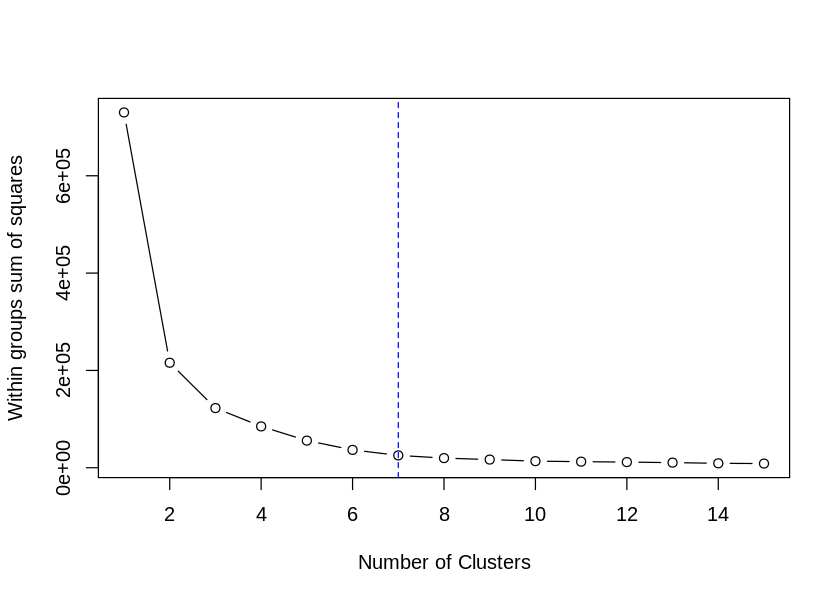

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 5)
wss <- (nrow(colData(se)$umap)-1) * sum(apply(colData(se)$umap, 2, var))
for (i in 2:15) wss[i] <- sum(kmeans(colData(se)$umap,centers = i, nstart = 10)$withinss)
options(repr.plot.width=7, repr.plot.height=5)
plot(1:15, wss, type="b", xlab="Number of Clusters", ylab="Within groups sum of squares")
n_cluster <- 7
abline(v = n_cluster, col = 'blue', lty = 2)

In [ ]:
set.seed(1)
# it is important to set nstart to a large number to get a relatively robust clustering result. 
cls <- kmeans(colData(se)$umap, n_cluster, nstart = 100)$cluster
table(cls, colData(se)$group)
cls <- as.numeric(factor(cls, c(4, 5, 2, 3, 1, 7, 6)))
table(cls, colData(se)$group)

   
cls MEF_NoDox MEF_Dox_D1 MEF_Dox_D2 MEF_Dox_D7a MEF_Dox_D7b
  1         1          0         17        1493           3
  2         0          6       1443           1           0
  3         0          4       1435          23           0
  4      2878        541         21           2           3
  5       657        381          1           0           0
  6         0          2          0           1         813
  7        26         14         19        5682           8

   
cls MEF_NoDox MEF_Dox_D1 MEF_Dox_D2 MEF_Dox_D7a MEF_Dox_D7b
  1      2878        541         21           2           3
  2       657        381          1           0           0
  3         0          6       1443           1           0
  4         0          4       1435          23           0
  5         1          0         17        1493           3
  6        26         14         19        5682           8
  7         0          2          0           1         813

# Seurat: converting Single cell experiment to seurat object

In [ ]:
system("wget -x -c -nH https://s3.msi.umn.edu/gongx030/etv2_pioneer/data/processed_Etv2_scRNAseq.rds")
sce = readRDS(file = "gongx030/etv2_pioneer/data/processed_Etv2_scRNAseq.rds")
sce = as(sce, "SingleCellExperiment")
print(sce)
rownames(sce) = rowData(sce)$name
colnames(sce)  = colData(sce)$barcodes
so = as.Seurat(sce, data = NULL)
so = CreateSeuratObject(counts = GetAssayData(so, slot = "counts"), meta.data = so@meta.data)
so[["percent.mt"]] = PercentageFeatureSet(so, pattern = "^mt-")
so[["percent.rpl"]] = PercentageFeatureSet(so, pattern = "^Rpl")
so[["percent.rps"]] = PercentageFeatureSet(so, pattern = "^Rps")
s.genes <- cc.genes$s.genes %>% str_to_title()
g2m.genes <- cc.genes$g2m.genes %>% str_to_title()
so <- CellCycleScoring(so, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
#normalize and scaling#
rownames(sce) = rownames(so)
colnames(sce) = colnames(so)
so <- SetAssayData(object = so, slot = "scale.data", new.data = assays(sce)$scaled_counts)
so <- SetAssayData(object = so, slot = "data", new.data = assays(sce)$normalized_counts)
#assign UMAP #
so[["umap"]] <- CreateDimReducObject(embeddings = as.matrix(so@meta.data[,c("umap.V1", "umap.V2")]), key = "umap_", assay = DefaultAssay(so))
so

class: SingleCellExperiment 
dim: 17010 15475 
metadata(1): curves
assays(3): counts normalized_counts scaled_counts
rownames: NULL
rowData names(6): id name ... is_hvg clusters
colnames: NULL
colData names(7): barcodes group ... umap cluster
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Non-unique cell names (colnames) present in the input matrix, making unique”
Warning message:
“The following features are not present in the object: Mlf1ip, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: Fam64a, Hn1, not searching for symbol synonyms”


An object of class Seurat 
17010 features across 15475 samples within 1 assay 
Active assay: RNA (17010 features, 0 variable features)
 1 dimensional reduction calculated: umap

# MEF_D7 Fl1+ vs MEF_ND

In [ ]:
X <- assays(se)$scaled_counts
control <- colData(se)$group == 'MEF_NoDox'
treatment <- colData(se)$group == 'MEF_Dox_D7b'
fc_ct <- rowMeans(X[, treatment]) - rowMeans(X[, control])
names(fc_ct) <- rowData(se)$name

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



In [ ]:
fc_ct <- na.omit(fc_ct)
fc_ct <- sort(fc_ct, decreasing = TRUE)

## Fold change arranged in descending order for GSEA

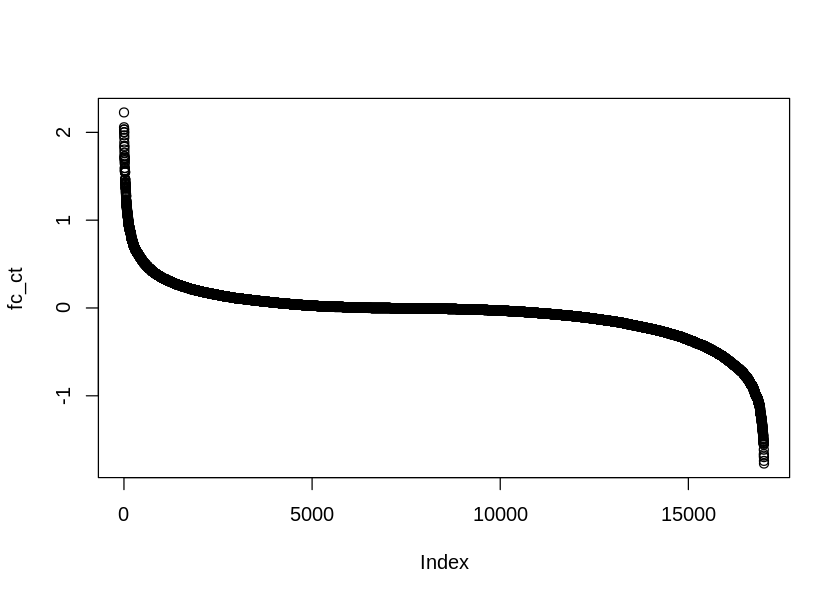

In [ ]:
plot(fc_ct)

## Gene set enrichment analysis using the genes from inflammatory terms

In [ ]:
set.seed(7)
fgseaRes <-  fgseaMultilevel(pathways = go_set, 
                  stats    = fc_ct,
                  minSize  = 1,
                  maxSize  = 2000,
                  nPermSimple = 50000)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are duplicate gene names, fgsea may produce unexpected results.”


In [ ]:
dat_d7 <- fgseaRes %>%
  mutate(val = ifelse(fgseaRes$ES > 0,
                                 log10(pval),
                                 -log10(pval))) #Log10 pval

In [ ]:
dat_d7$ES_score <- ifelse(dat_d7$ES > 0, "lightblue", "lightblue")

In [ ]:
gs <- dat_d7 %>% 
arrange(val)

In [ ]:
gs

pathway,pval,padj,log2err,ES,NES,size,leadingEdge,val,ES_score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>,<dbl>,<chr>
B cell receptor signaling pathway,6.751028e-05,0.001687757,0.538434096,0.6907049,1.9748750,39,"Cd81 , Vav3 , Lyn , Cd38 , Cmtm3, Klhl6, Abl1 , Mef2c",-4.17063012,lightblue
Fc receptor mediated stimulatory signaling pathway,9.821787e-04,0.012277234,0.455059867,0.8287541,1.8668336,14,"Cd47 , Plscr1, Lyn , Appl2 , Rap1a",-3.00780948,lightblue
Fc-gamma receptor signaling pathway,4.395866e-03,0.036632213,0.168154339,0.8144783,1.7654641,12,"Cd47 , Appl2, Rap1a",-2.35695560,lightblue
Fc-gamma receptor signaling pathway involved in phagocytosis,1.393497e-02,0.068402919,0.090742400,0.8436575,1.6436426,8,"Cd47 , Appl2, Rap1a",-1.85589396,lightblue
immune response-regulating cell surface receptor signaling pathway involved in phagocytosis,1.393497e-02,0.068402919,0.090742400,0.8436575,1.6436426,8,"Cd47 , Appl2, Rap1a",-1.85589396,lightblue
immune response-regulating signaling pathway,1.641670e-02,0.068402919,0.160665976,0.3650546,1.2978937,157,"Cd81 , Cd47 , Lax1 , Vav3 , Plscr1 , Lyn , Cd38 , Cmtm3 , Klhl6 , Abl1 , Appl2 , Pde4b , Mef2c , Rap1a , Fyn , Tlr4 , Psen2 , Dusp3 , Phpt1 , H2-M3 , Sppl3 , Dennd1b, Nfkbiz , Plcg1 , Elf1 , Ctsh",-1.78471413,lightblue
immune response-regulating cell surface receptor signaling pathway,2.317750e-02,0.073855244,0.133506897,0.3569677,1.2661629,154,"Cd81 , Cd47 , Lax1 , Vav3 , Plscr1 , Lyn , Cd38 , Cmtm3 , Klhl6 , Abl1 , Appl2 , Pde4b , Mef2c , Rap1a , Fyn , Psen2 , Dusp3 , Phpt1 , H2-M3 , Sppl3 , Dennd1b, Nfkbiz , Plcg1 , Elf1",-1.63493348,lightblue
immune response-activating cell surface receptor signaling pathway,2.363368e-02,0.073855244,0.127603887,0.3643429,1.2826267,144,"Cd81 , Cd47 , Lax1 , Vav3 , Plscr1 , Lyn , Cd38 , Cmtm3 , Klhl6 , Abl1 , Appl2 , Pde4b , Mef2c , Rap1a , Fyn , Psen2 , Dusp3 , Phpt1 , Sppl3 , Dennd1b, Nfkbiz , Plcg1 , Elf1",-1.62646869,lightblue
Fc receptor signaling pathway,2.904747e-02,0.080687415,0.066845942,0.6786401,1.5786192,16,"Cd47 , Appl2, Rap1a",-1.53689170,lightblue


## Plot of infammatory related terms with a significant pvalue and arranged according to the pvalue.

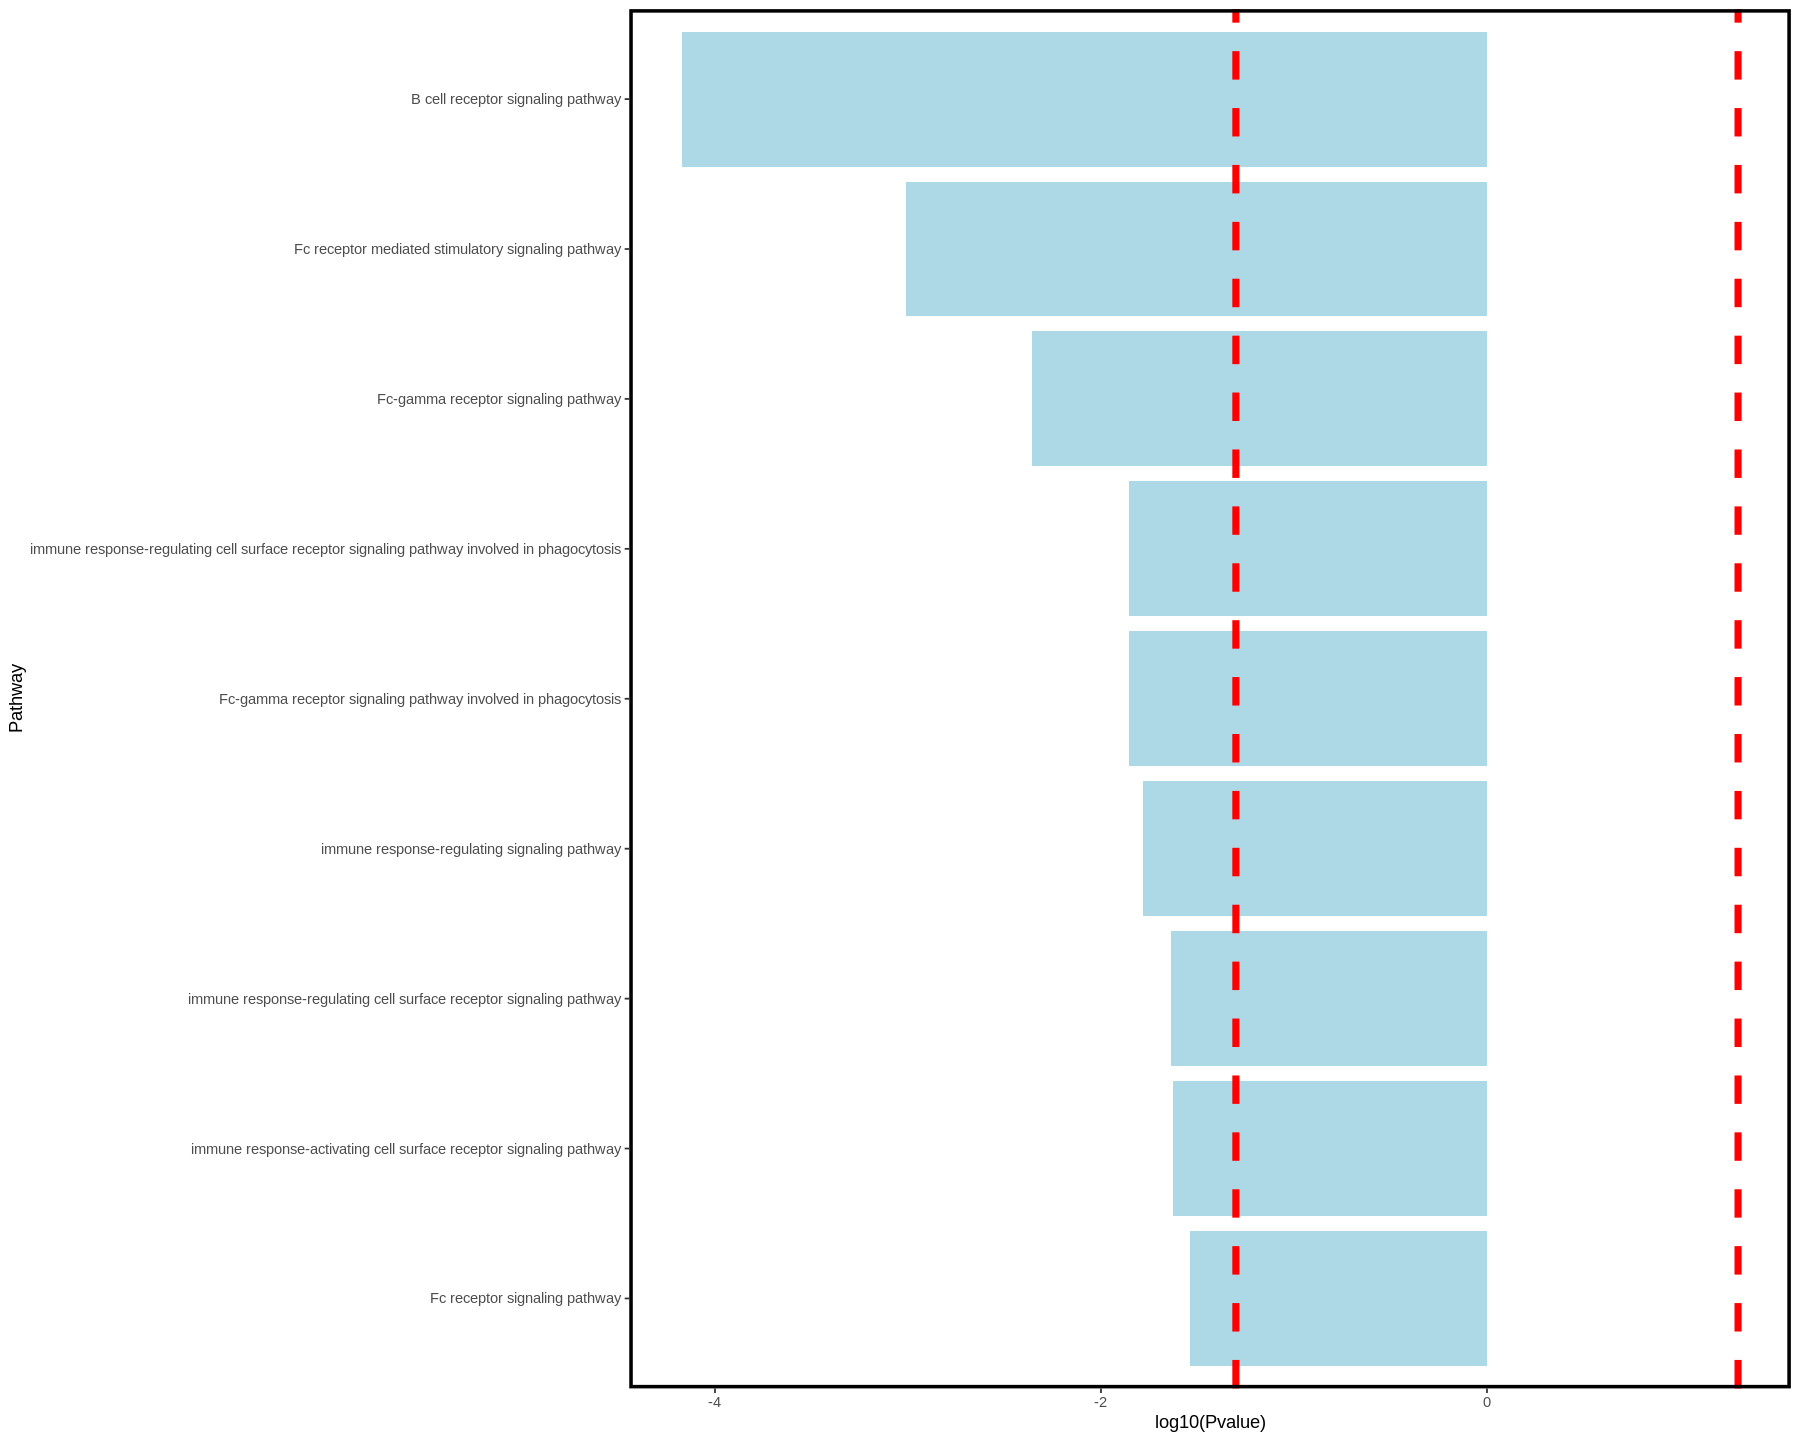

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 12)
ggplot(gs[gs$pval < 0.05 & gs$size > 5,],aes(x = reorder(pathway, -val), y = val, fill = ES_score)) + 
geom_bar(stat = 'identity') + 
coord_flip() +
scale_fill_identity()  + 
geom_hline(yintercept=log10(0.05), color = 'red', linetype='dashed', size = 2) + 
geom_hline(yintercept= -log10(0.05), color = 'red', linetype='dashed', size = 2) + 
xlab('Pathway') + ylab('log10(Pvalue)') +
theme_bw() + 
theme(panel.border = element_rect(colour = 'black', size = 2), panel.grid.major = element_blank(),
panel.grid.minor = element_blank())

# MEF D1 vs MEF ND

In [ ]:
X <- assays(se)$scaled_counts
control <- colData(se)$group == 'MEF_NoDox'
treatment <- colData(se)$group == 'MEF_Dox_D1'
fc_ct <- rowMeans(X[, treatment]) - rowMeans(X[, control])
names(fc_ct) <- rowData(se)$name

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



In [ ]:
fc_ct <- na.omit(fc_ct)
fc_ct <- sort(fc_ct, decreasing = TRUE)

## Fold change arranged in descending order for GSEA

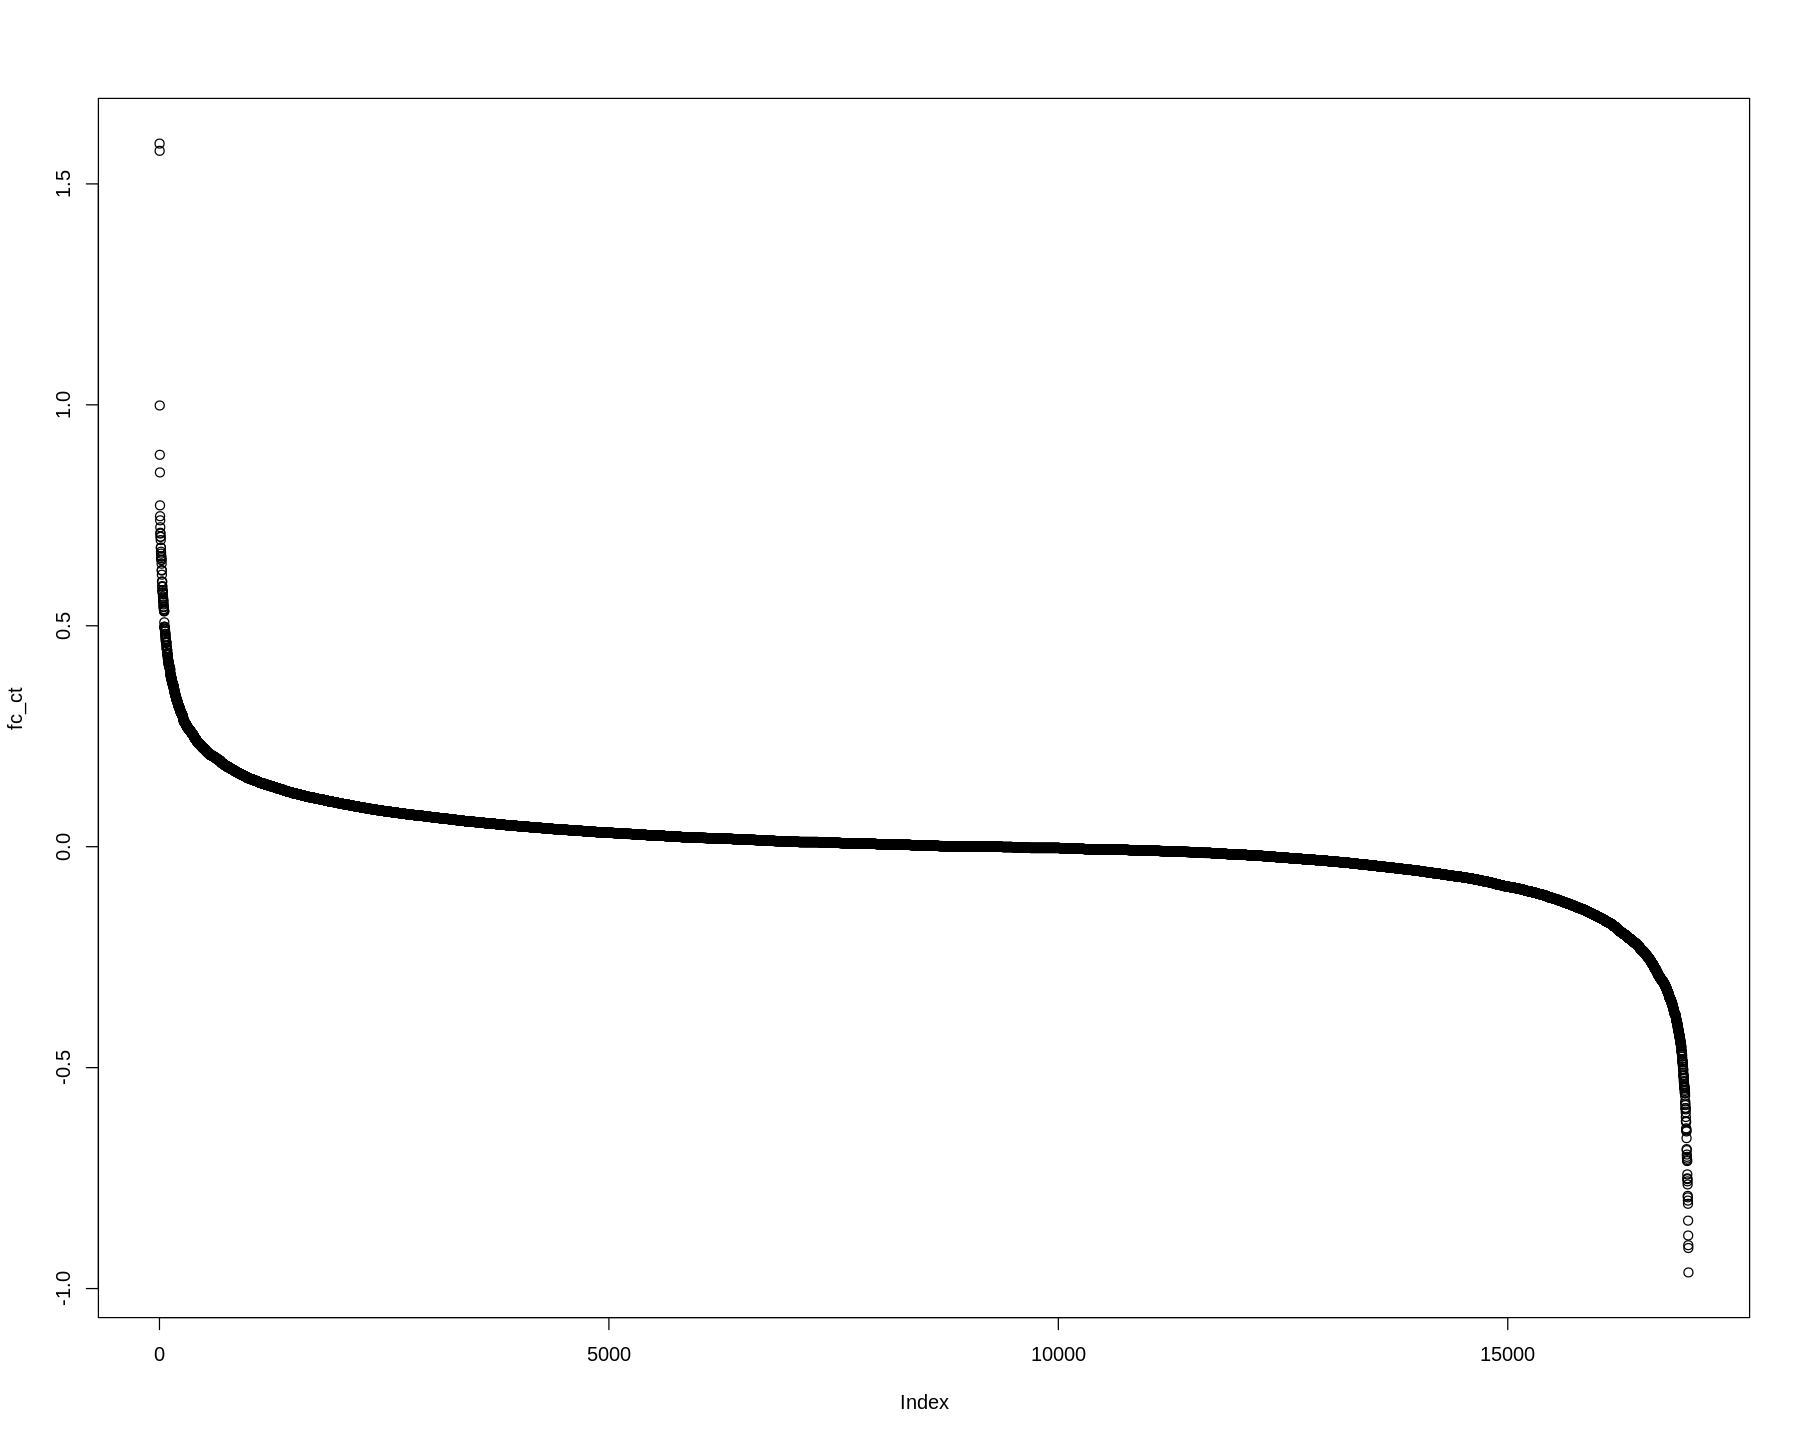

In [ ]:
plot(fc_ct)

## Gene set enrichment analysis using the genes from inflammatory terms

In [ ]:
set.seed(7)
fgseaRes <-  fgseaMultilevel(pathways = go_set, 
                  stats    = fc_ct,
                  minSize  = 1,
                  maxSize  = 2000,
                  nPermSimple = 50000)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are duplicate gene names, fgsea may produce unexpected results.”


In [ ]:
dat_d1 <- fgseaRes %>%
  mutate(val = ifelse(fgseaRes$ES > 0,
                                 log10(pval),
                                 -log10(pval))) #Log10 pval

In [ ]:
dat_d1$ES_score <- ifelse(dat_d1$ES > 0, "lightblue", "lightblue")

In [ ]:
gs_d1 <- dat_d1 %>% 
arrange(val)

## Plot of infammatory related terms with a significant pvalue and arranged according to the pvalue.

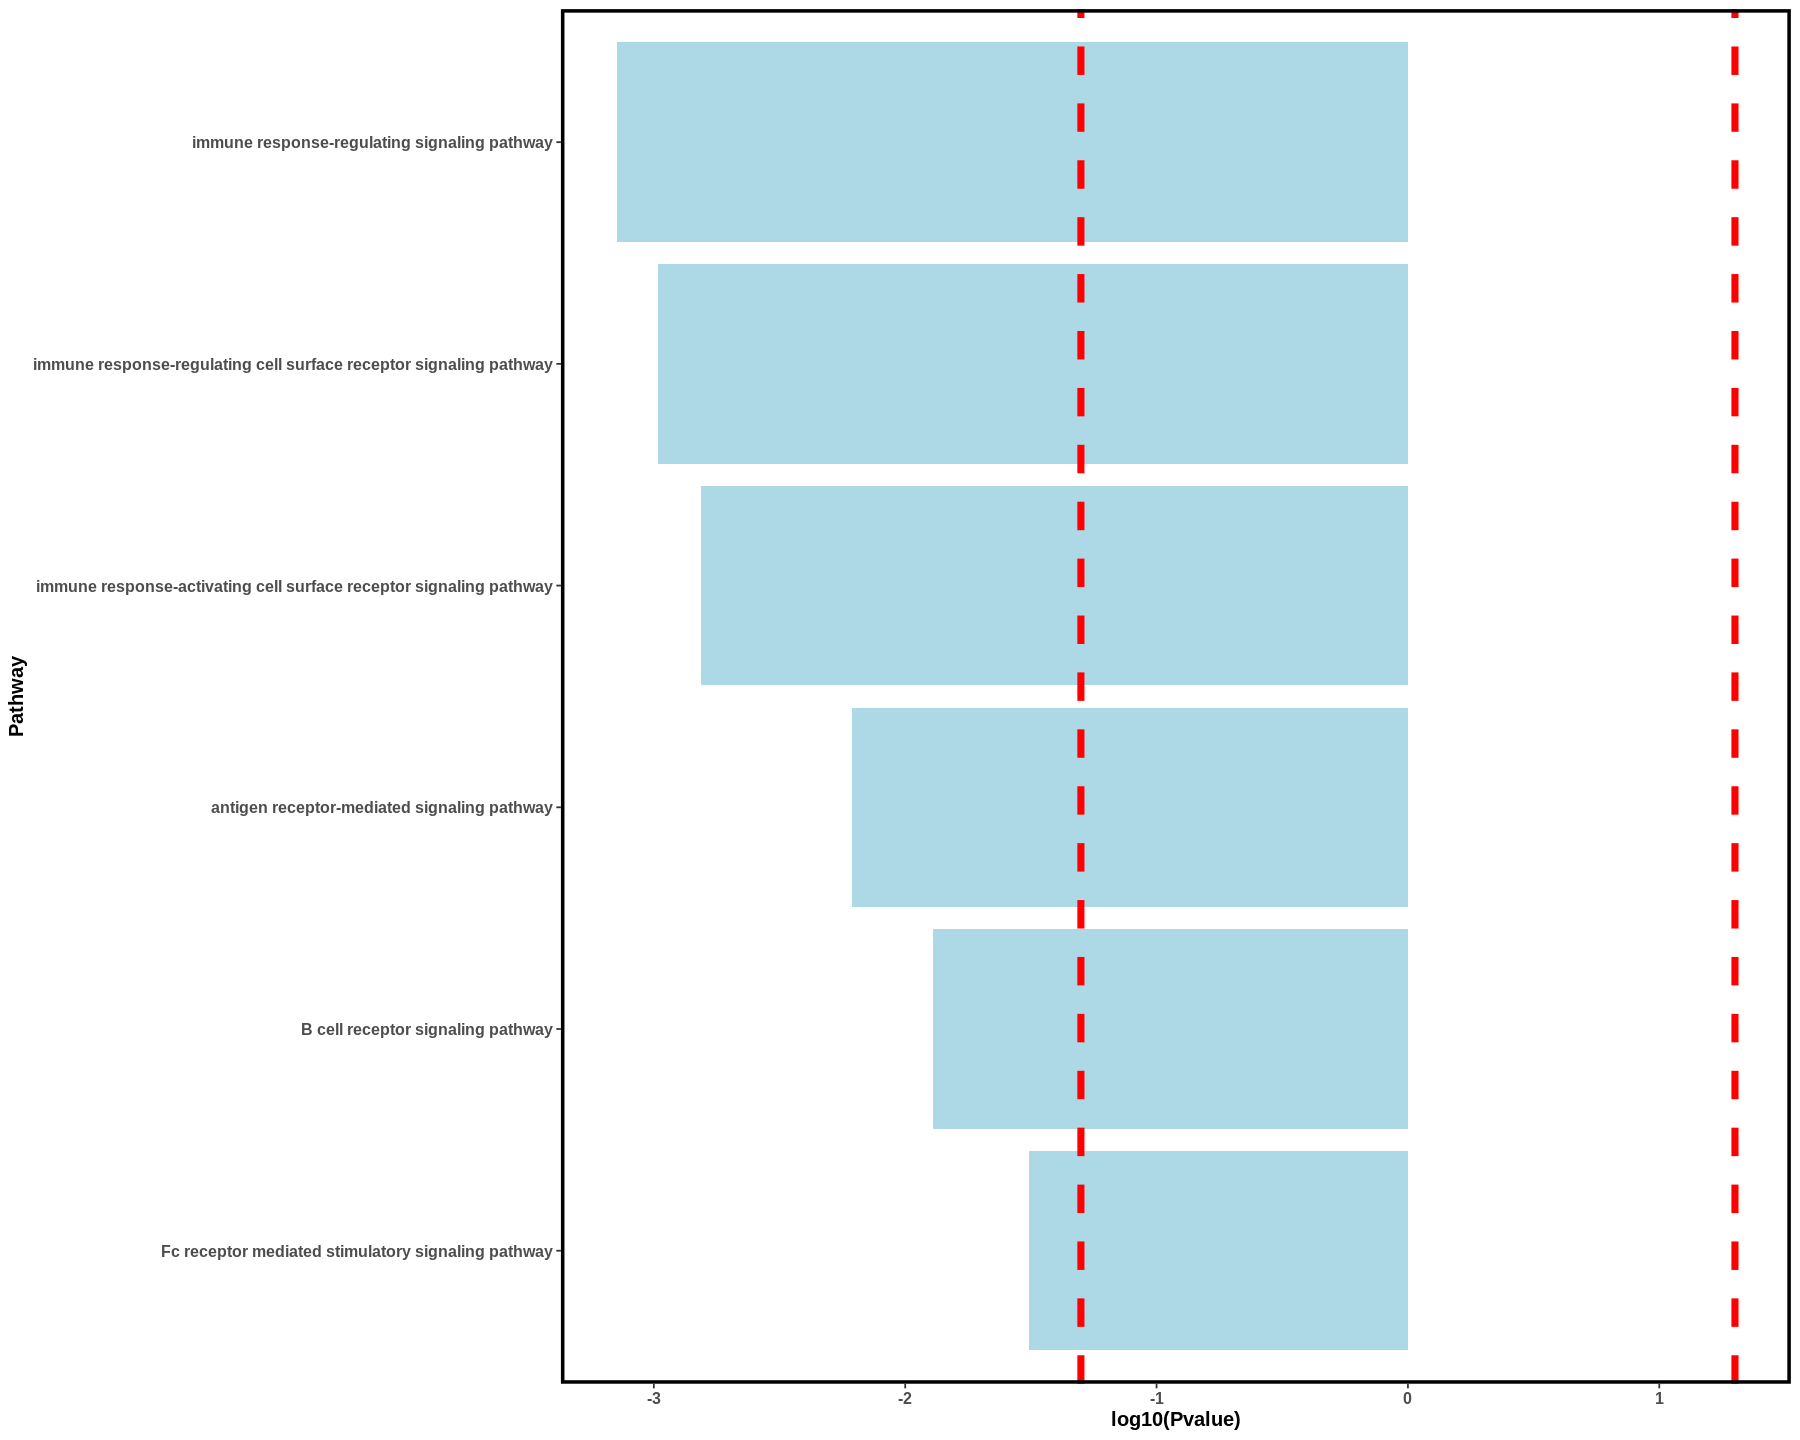

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 12)
ggplot(gs_d1[gs_d1$pval < 0.05 & gs_d1$size > 5,],aes(x = reorder(pathway, -val), y = val, fill = ES_score)) + 
geom_bar(stat = 'identity') + 
coord_flip() +
scale_fill_identity()  + 
geom_hline(yintercept=log10(0.05), color = 'red', linetype='dashed', size = 2) + 
geom_hline(yintercept= -log10(0.05), color = 'red', linetype='dashed', size = 2) + 
xlab('Pathway') + ylab('log10(Pvalue)') +
theme_bw() + 
theme(panel.border = element_rect(colour = 'black', size = 2), panel.grid.major = element_blank(),
panel.grid.minor = element_blank()) + 
theme(text=element_text(size=12, family="Arial", face="bold")) 


In [ ]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] SeuratObject_4.0.2                       
 [2] Seurat_4.0.5                             
 [3] SingleCellExperiment_1.14.1              
 [4] Mus.musculus_1.3.1                       
 [5] OrganismDbi_1.34.0                       
 [6] GOfunc

In [ ]:
Sys.time() - start_time0

Time difference of 30.55582 mins